# TMDB Movie Data Analysis using Spark and APIs

## Step 1: API Setup and Data Extraction

This section focuses on setting up the TMDB API connection and extracting movie data. We'll use PySpark for distributed data processing and the TMDB API to fetch detailed movie information including cast, crew, and financial data.

### Import Necessary Modules

Start by importing the required libraries for:
- **PySpark**: Distributed data processing and analysis
- **API calls**: HTTP requests to TMDB API
- **Data manipulation**: NumPy for numerical operations
- **Environment management**: Secure API key handling
- **Visualization**: Matplotlib for data plotting

In [1]:
# Initialize Spark Session for distributed data processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Create Spark session with adaptive query execution enabled
spark = SparkSession.builder \
        .appName("TMDB Movie Data Analysis") \
        .config("spark.sql.adaptive.enabled", "true") \
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/09 07:28:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import additional libraries for API calls and data analysis
import os
from dotenv import load_dotenv
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time  # For handling API rate limits

### Environment Configuration

Load environment variables from .env file to securely access the TMDB API key without hardcoding sensitive information.

In [3]:
# Load environment variables from .env file
load_dotenv()

True

### API Key Configuration

Retrieve the TMDB API key from environment variables. This approach ensures:
- Security: API keys are not exposed in code
- Flexibility: Easy to change keys without code modification
- Best practices: Following secure development standards

In [4]:
# Retrieve TMDB API key from environment variables
API_KEY = os.getenv('TMDB_API_KEY')

# Validate API key is loaded
if not API_KEY:
    raise ValueError("TMDB_API_KEY not found in environment variables. Please check your .env file.")

### Movie Data Extraction with Error Handling

This section implements robust movie data fetching with comprehensive error handling:

**Features:**
- **Timeout handling**: Prevents hanging requests
- **HTTP error handling**: Manages API response errors
- **Connection error handling**: Handles network issues
- **Rate limiting**: Respects API usage limits
- **Data validation**: Ensures safe data access
- **Progress tracking**: Shows real-time processing status

**Data collected for each movie:**
- Basic info: Title, release date, runtime, budget, revenue
- Ratings: Vote average and count
- Cast: Top 5 actors and total cast size
- Crew: Director and total crew size
- Genres and production details

In [5]:
# List of popular movie IDs from TMDB (including one invalid ID for testing error handling)
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397,
    420818, 24428, 168259, 99861, 284054, 12445,
    181808, 330457, 351286, 109445, 321612, 260513
]

# TMDB API configuration
base_url = "https://api.themoviedb.org/3/movie"
params = {"api_key": API_KEY, "language": "en-US"}

# Initialize lists to store results
movies_data = []
failed_requests = []  # Track failed requests for analysis

print("Starting movie data extraction...")

for i, movie_id in enumerate(movie_ids, 1):
    try:
        print(f"Processing movie {i}/{len(movie_ids)} (ID: {movie_id})...", end=" ")
        
        # Fetch movie details with timeout and error handling
        movie_url = f"{base_url}/{movie_id}"
        movie_response = requests.get(movie_url, params=params, timeout=10)
        movie_response.raise_for_status()  # Raises HTTPError for bad responses
        
        data = movie_response.json()
        
        # Fetch credits with nested error handling
        try:
            credits_url = f"{base_url}/{movie_id}/credits"
            credits_response = requests.get(credits_url, params=params, timeout=10)
            credits_response.raise_for_status()
            
            credits = credits_response.json()
            
            # Extract main cast (top 5 names) with safe access
            cast_list = [member.get("name", "Unknown") for member in credits.get("cast", [])[:5]]
            cast_names = "|".join(cast_list) if cast_list else "No cast data"
            cast_size = len(credits.get("cast", []))
            
            # Extract directors from crew with safe access
            crew = credits.get("crew", [])
            directors = [m.get("name") for m in crew if m.get("job") == "Director" and m.get("name")]
            director_name = directors[0] if directors else "Unknown Director"
            crew_size = len(crew)
            
            # Add credit info to movie data
            data["cast"] = cast_names
            data["cast_size"] = cast_size
            data["director"] = director_name
            data["crew_size"] = crew_size
            
        except requests.exceptions.RequestException as e:
            print(f"Credits fetch failed: {str(e)[:50]}...")
            # Set default values if credits fetch fails
            data["cast"] = "Credits unavailable"
            data["cast_size"] = 0
            data["director"] = "Unknown Director"
            data["crew_size"] = 0
        
        except Exception as e:
            print(f"Credits processing error: {str(e)[:50]}...")
            data["cast"] = "Processing error"
            data["cast_size"] = 0
            data["director"] = "Unknown Director"
            data["crew_size"] = 0
        
        movies_data.append(data)
        print(f"Fetched movie: {data.get('title', 'Unknown Title')} (ID: {movie_id})")
        
        # Add small delay to respect API rate limits
        time.sleep(0.1)
        
    except requests.exceptions.HTTPError as e:
        error_msg = f"HTTP Error {e.response.status_code}: {e.response.reason}"
        print(f"Failed to fetch movie with ID: {movie_id}")
        failed_requests.append({"movie_id": movie_id, "error": error_msg})
        
    except requests.exceptions.Timeout:
        error_msg = "Request timeout (>10s)"
        print(f"Timeout error for movie ID: {movie_id}")
        failed_requests.append({"movie_id": movie_id, "error": error_msg})
        
    except requests.exceptions.ConnectionError:
        error_msg = "Connection error - check internet connection"
        print(f"Connection error for movie ID: {movie_id}")
        failed_requests.append({"movie_id": movie_id, "error": error_msg})
        
    except requests.exceptions.RequestException as e:
        error_msg = f"Request error: {str(e)[:50]}..."
        print(f"Request error for movie ID: {movie_id}")
        failed_requests.append({"movie_id": movie_id, "error": error_msg})
        
    except Exception as e:
        error_msg = f"Unexpected error: {str(e)[:50]}..."
        print(f"Unexpected error for movie ID: {movie_id}")
        failed_requests.append({"movie_id": movie_id, "error": error_msg})

# Summary of data extraction
print(f"\n=== Data Extraction Summary ===")
print(f"Total movies requested: {len(movie_ids)}")
print(f"Successfully fetched: {len(movies_data)}")
print(f"Failed requests: {len(failed_requests)}")

if failed_requests:
    print("\nFailed requests details:")
    for failure in failed_requests:
        print(f"  - Movie ID {failure['movie_id']}: {failure['error']}")

Starting movie data extraction...
Processing movie 1/19 (ID: 0)... ERROR! Session/line number was not unique in database. History logging moved to new session 24
Failed to fetch movie with ID: 0
Processing movie 2/19 (ID: 299534)... Fetched movie: Avengers: Endgame (ID: 299534)
Processing movie 3/19 (ID: 19995)... Fetched movie: Avatar (ID: 19995)
Processing movie 4/19 (ID: 140607)... Fetched movie: Star Wars: The Force Awakens (ID: 140607)
Processing movie 5/19 (ID: 299536)... Fetched movie: Avengers: Infinity War (ID: 299536)
Processing movie 6/19 (ID: 597)... Fetched movie: Titanic (ID: 597)
Processing movie 7/19 (ID: 135397)... Fetched movie: Jurassic World (ID: 135397)
Processing movie 8/19 (ID: 420818)... Fetched movie: The Lion King (ID: 420818)
Processing movie 9/19 (ID: 24428)... Fetched movie: The Avengers (ID: 24428)
Processing movie 10/19 (ID: 168259)... Fetched movie: Furious 7 (ID: 168259)
Processing movie 11/19 (ID: 99861)... Fetched movie: Avengers: Age of Ultron (ID: 9

## Convert movies_data to Saprk DataFrame

In [6]:
# Create Spark DataFrame from movies_data
df = spark.createDataFrame(movies_data)

# Display basic info
print(f"Created DataFrame with {df.count()} movies")
print(f"DataFrame columns: {len(df.columns)}")

# Show first few rows
df.select('title', 'release_date', 'vote_average', 'budget', 'revenue').show(3, truncate=False)


25/12/09 07:29:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Created DataFrame with 18 movies
DataFrame columns: 30
+----------------------------+------------+------------+---------+----------+
|title                       |release_date|vote_average|budget   |revenue   |
+----------------------------+------------+------------+---------+----------+
|Avengers: Endgame           |2019-04-24  |8.237       |356000000|2799439100|
|Avatar                      |2009-12-15  |7.594       |237000000|2923706026|
|Star Wars: The Force Awakens|2015-12-15  |7.3         |245000000|2068223624|
+----------------------------+------------+------------+---------+----------+
only showing top 3 rows


## Step 2: Data Cleaning and Preprocessing

### Data Preparation & Cleaning

1. **Drop** irrelevant columns: ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
2. **Evaluate** JSON-like columns (['belongs_to_collection', 'genres', 'production_countries', 'production_companies', 'spoken_languages'])
3. **Extract** and clean key data points:
   - Collection name (belongs_to_collection)
   - Genre names (genres → separate multiple genres with "|")
   - Spoken languages (spoken_languages → separate with "|")
   - Production countries (production_countries → separate with "|")
   - Production companies (production_companies → separate with "|")
4. **Inspect** extracted columns using value_counts() to identify anomalies

### Handling Missing & Incorrect Data

5. **Convert** column datatypes:
   - 'budget', 'id', 'popularity' → Numeric (set invalid values to NaN)
   - 'release_date' → Convert to datetime
6. **Replace unrealistic values**:
   - Budget/Revenue/Runtime = 0 → Replace with NaN
   - Convert 'budget' and 'revenue' to million USD
   - Movies with vote_count = 0 → Analyze their vote_average and adjust accordingly
   - 'overview' and 'tagline' → Replace known placeholders (e.g., 'No Data') with NaN
7. **Remove duplicates** and drop rows with unknown 'id' or 'title'
8. **Keep** only rows where at least **10 columns have non-NaN values**
9. **Filter** to include only 'Released' movies, then drop 'status'

### Reorder & Finalize DataFrame

10. **Reorder columns**: ['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']
11. **Reset index**


### 2.1 Drop irrelevant columns


In [7]:
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
df1 = df.drop(*cols_to_drop)

print(f"Columns after dropping: {len(df.columns)}")
df1.columns

Columns after dropping: 30


['backdrop_path',
 'belongs_to_collection',
 'budget',
 'cast',
 'cast_size',
 'crew_size',
 'director',
 'genres',
 'id',
 'origin_country',
 'original_language',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count']

### 2.2  Evaluate JSON-like columns

In [8]:
# Fix the JSON cleaning with simpler regex patterns
df2 = df1.withColumn("collection_name", 
    when(col("belongs_to_collection").isNotNull(), 
         col("belongs_to_collection")["name"])
    .otherwise(None))

df2 = df2.withColumn("genres", 
    regexp_replace(
        regexp_replace(to_json(col("genres")), "\\[|\\]|\\{|\\}", ""),
        '"name":', ""
    ))

df2 = df2.withColumn("production_countries",
    regexp_replace(
        regexp_replace(to_json(col("production_countries")), "\\[|\\]|\\{|\\}", ""),
        '"name":', ""
    ))

df2 = df2.withColumn("production_companies",
    regexp_replace(
        regexp_replace(to_json(col("production_companies")), "\\[|\\]|\\{|\\}", ""),
        '"name":', ""
    ))

df2 = df2.withColumn("spoken_languages",
    regexp_replace(
        regexp_replace(to_json(col("spoken_languages")), "\\[|\\]|\\{|\\}", ""),
        '"english_name":', ""
    ))

df2 = df2.drop("belongs_to_collection")

# Inspect extracted columns using value_counts
for col_name in ["collection_name", "genres", "spoken_languages", "production_countries"]:
    print(f"\nColumn: {col_name}")
    df2.groupBy(col_name).count().orderBy(desc("count")).show()



Column: collection_name


+--------------------+-----+
|     collection_name|count|
+--------------------+-----+
|The Avengers Coll...|    4|
|Star Wars Collection|    2|
|                NULL|    2|
|Jurassic Park Col...|    2|
|   Frozen Collection|    2|
|   Avatar Collection|    1|
|The Lion King (Re...|    1|
|The Fast and the ...|    1|
|Harry Potter Coll...|    1|
|Black Panther Col...|    1|
|The Incredibles C...|    1|
+--------------------+-----+


Column: genres
+--------------------+-----+
|              genres|count|
+--------------------+-----+
|"Adventure","id":...|    3|
|"Action","id":"28...|    2|
|"Action","id":"28...|    2|
|"Action","id":"28...|    1|
|"Adventure","id":...|    1|
|"Drama","id":"18"...|    1|
|"Science Fiction"...|    1|
|"Adventure","id":...|    1|
|"Action","id":"28...|    1|
|"Adventure","id":...|    1|
|"Family","id":"10...|    1|
|"Family","id":"10...|    1|
|"Action","id":"28...|    1|
|"Animation","id":...|    1|
+--------------------+-----+


Column: spoken_languages

In [9]:
# Inspect extracted columns using value_counts
for col_name in ["collection_name", "genres", "spoken_languages", "production_countries"]:
    print(f"\nColumn: {col_name}")
    df2.groupBy(col_name).count().orderBy(desc("count")).show()



Column: collection_name
+--------------------+-----+
|     collection_name|count|
+--------------------+-----+
|The Avengers Coll...|    4|
|Star Wars Collection|    2|
|                NULL|    2|
|Jurassic Park Col...|    2|
|   Frozen Collection|    2|
|   Avatar Collection|    1|
|The Lion King (Re...|    1|
|The Fast and the ...|    1|
|Harry Potter Coll...|    1|
|Black Panther Col...|    1|
|The Incredibles C...|    1|
+--------------------+-----+


Column: genres
+--------------------+-----+
|              genres|count|
+--------------------+-----+
|"Adventure","id":...|    3|
|"Action","id":"28...|    2|
|"Action","id":"28...|    2|
|"Action","id":"28...|    1|
|"Adventure","id":...|    1|
|"Drama","id":"18"...|    1|
|"Science Fiction"...|    1|
|"Adventure","id":...|    1|
|"Action","id":"28...|    1|
|"Adventure","id":...|    1|
|"Family","id":"10...|    1|
|"Family","id":"10...|    1|
|"Action","id":"28...|    1|
|"Animation","id":...|    1|
+--------------------+-----+



### 2.3 Extract and clean key data points

In [10]:
# Collection name
df2 = df1.withColumn("collection_name", 
    when(col("belongs_to_collection").isNotNull(), 
         col("belongs_to_collection")["name"])
    .otherwise(None))

# Genre names (separate with "|")
df2 = df2.withColumn("genres", 
    expr("transform(genres, x -> x.name)")).withColumn("genres", 
    concat_ws("|", col("genres")))

# Spoken languages (separate with "|")
df2 = df2.withColumn("spoken_languages",
    expr("transform(spoken_languages, x -> x.english_name)")).withColumn("spoken_languages",
    concat_ws("|", col("spoken_languages")))

# Production countries (separate with "|")
df2 = df2.withColumn("production_countries",
    expr("transform(production_countries, x -> x.name)")).withColumn("production_countries",
    concat_ws("|", col("production_countries")))

# Production companies (separate with "|")
df2 = df2.withColumn("production_companies",
    expr("transform(production_companies, x -> x.name)")).withColumn("production_companies",
    concat_ws("|", col("production_companies")))

df2 = df2.drop("belongs_to_collection")


### 2.4 Inspect Extracted columns

In [11]:
# Inspect extracted columns using value_counts to identify anomalies
for col_name in ["collection_name", "genres", "spoken_languages", "production_countries", "production_companies"]:
    print(f"\nColumn: {col_name}")
    df2.groupBy(col_name).count().orderBy(desc("count")).show(10)



Column: collection_name
+--------------------+-----+
|     collection_name|count|
+--------------------+-----+
|The Avengers Coll...|    4|
|Star Wars Collection|    2|
|                NULL|    2|
|Jurassic Park Col...|    2|
|   Frozen Collection|    2|
|   Avatar Collection|    1|
|The Lion King (Re...|    1|
|The Fast and the ...|    1|
|Harry Potter Coll...|    1|
|Black Panther Col...|    1|
+--------------------+-----+
only showing top 10 rows

Column: genres


+--------------------+-----+
|              genres|count|
+--------------------+-----+
|Adventure|Action|...|    3|
|Action|Adventure|...|    2|
|Action|Adventure|...|    2|
|Adventure|Science...|    1|
|Action|Adventure|...|    1|
|       Drama|Romance|    1|
|Adventure|Drama|F...|    1|
|Science Fiction|A...|    1|
|Action|Crime|Thri...|    1|
|   Adventure|Fantasy|    1|
+--------------------+-----+
only showing top 10 rows

Column: spoken_languages


+--------------------+-----+
|    spoken_languages|count|
+--------------------+-----+
|             English|    9|
|     English|Spanish|    1|
|English|Japanese|...|    1|
|       English|Xhosa|    1|
|English|French|Ge...|    1|
|English|Hindi|Rus...|    1|
|Arabic|English|Sp...|    1|
|English|Korean|Sw...|    1|
|     English|Russian|    1|
|      English|French|    1|
+--------------------+-----+


Column: production_countries
+--------------------+-----+
|production_countries|count|
+--------------------+-----+
|United States of ...|   16|
|United States of ...|    1|
|United Kingdom|Un...|    1|
+--------------------+-----+


Column: production_companies
+--------------------+-----+
|production_companies|count|
+--------------------+-----+
|      Marvel Studios|    5|
|Walt Disney Anima...|    2|
|Dune Entertainmen...|    1|
|Lucasfilm Ltd.|Ba...|    1|
|Amblin Entertainm...|    1|
|Paramount Picture...|    1|
|Walt Disney Pictu...|    1|
|Original Film|One...|    1|
|Warner Br

### 2.5 Convert Column Datatypes

In [12]:
# Convert to numeric (invalid values become null)
df3 = df2.withColumn("budget", col("budget").cast(DoubleType()))
df3 = df3.withColumn("id", col("id").cast(IntegerType()))  
df3 = df3.withColumn("popularity", col("popularity").cast(DoubleType()))

# Convert to datetime
df3 = df3.withColumn("release_date", to_date(col("release_date")))
df3.dtypes


[('backdrop_path', 'string'),
 ('budget', 'double'),
 ('cast', 'string'),
 ('cast_size', 'bigint'),
 ('crew_size', 'bigint'),
 ('director', 'string'),
 ('genres', 'string'),
 ('id', 'int'),
 ('origin_country', 'array<string>'),
 ('original_language', 'string'),
 ('overview', 'string'),
 ('popularity', 'double'),
 ('poster_path', 'string'),
 ('production_companies', 'string'),
 ('production_countries', 'string'),
 ('release_date', 'date'),
 ('revenue', 'bigint'),
 ('runtime', 'bigint'),
 ('spoken_languages', 'string'),
 ('status', 'string'),
 ('tagline', 'string'),
 ('title', 'string'),
 ('vote_average', 'double'),
 ('vote_count', 'bigint'),
 ('collection_name', 'string')]

### 2.6  Replace unrealistic values

In [13]:
# Replace 0 values with null for budget, revenue, runtime
df4 = df3.withColumn("budget", when(col("budget") == 0, lit(None)).otherwise(col("budget"))) \
         .withColumn("revenue", when(col("revenue") == 0, lit(None)).otherwise(col("revenue"))) \
         .withColumn("runtime", when(col("runtime") == 0, lit(None)).otherwise(col("runtime")))

# Convert budget and revenue to million USD
df4 = df4.withColumn("budget_musd", col("budget") / 1000000) \
         .withColumn("revenue_musd", col("revenue") / 1000000)

# Handle vote_count = 0 by setting vote_average to null
df4 = df4.withColumn("vote_average", when(col("vote_count") == 0, lit(None)).otherwise(col("vote_average")))

# Replace placeholder text with null in overview and tagline
df4 = df4.withColumn("overview", when(col("overview").isin("No Data", ""), lit(None)).otherwise(col("overview"))) \
         .withColumn("tagline", when(col("tagline").isin("No Data", ""), lit(None)).otherwise(col("tagline")))


### Verify 2.6

In [14]:
# Check for zero values before replacement
df4.select("budget", "revenue", "runtime", "vote_count").describe().show()

# Check for placeholder text
df4.select("overview", "tagline").filter(col("overview").isin("No Data", "") | col("tagline").isin("No Data", "")).show()

# Verify new million USD columns
df4.select("budget", "budget_musd", "revenue", "revenue_musd").show()


+-------+--------------------+--------------------+------------------+------------------+
|summary|              budget|             revenue|           runtime|        vote_count|
+-------+--------------------+--------------------+------------------+------------------+
|  count|                  18|                  18|                18|                18|
|   mean| 2.137777777777778E8|1.6918318277222223E9|138.05555555555554|20437.055555555555|
| stddev|6.1959717042185664E7| 5.210622853292365E8| 23.84871983793882| 7755.438368709384|
|    min|              1.25E8|          1243225667|               102|             10078|
|    max|              3.56E8|          2923706026|               194|             34325|
+-------+--------------------+--------------------+------------------+------------------+

+--------+-------+
|overview|tagline|
+--------+-------+
+--------+-------+

+------+-----------+----------+------------+
|budget|budget_musd|   revenue|revenue_musd|
+------+-----------+--

count null values

In [15]:
# Count null values in each column
df4.select([sum(when(isnull(c), 1).otherwise(0)).alias(c) for c in df4.columns]).show()


+-------------+------+----+---------+---------+--------+------+---+--------------+-----------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+---------------+-----------+------------+
|backdrop_path|budget|cast|cast_size|crew_size|director|genres| id|origin_country|original_language|overview|popularity|poster_path|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|collection_name|budget_musd|revenue_musd|
+-------------+------+----+---------+---------+--------+------+---+--------------+-----------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+---------------+-----------+------------+
|            0|     0|   0|        0|        0|       0|     0|  0|            

### 2.7 Remove duplicates

In [16]:
# Filter rows with non-null id and title, then remove duplicates by id
df5 = df4.filter(col("id").isNotNull() & col("title").isNotNull()).dropDuplicates(["id"])


**Verify 2.7**

In [17]:
print(f"Before filtering: {df4.count()}")
print(f"After filtering: {df5.count()}")


Before filtering: 18


After filtering: 18


**2.8** **Keep** only rows where at least **10 columns have non-NaN values**.

In [18]:
# Keep rows with at least 10 non-null values
from functools import reduce
non_null_count = reduce(lambda x, y: x + y, [when(col(c).isNotNull(), 1).otherwise(0) for c in df5.columns])
df6 = df5.withColumn("non_null_count", non_null_count).filter(col("non_null_count") >= 10).drop("non_null_count")


We filtered out rows that have fewer than 10 non-null columns. Since no rows were removed (18 → 18), it means all your movies already have at least 10 columns with valid data, which indicates good data quality from the API.

This step is a data quality check - in larger datasets, you might have incomplete records that should be excluded from analysis.

In [19]:
print(f"Before filtering: {df5.count()}")
print(f"After filtering: {df6.count()}")


Before filtering: 18


After filtering: 18


**2.9**. **Filter** to include only 'Released' movies, then drop 'status'.


In [20]:
# Filter for Released movies and drop status column
df7 = df6.filter(col("status") == "Released").drop("status")


In [21]:
print(f"Before filtering: {df6.count()}")
print(f"After filtering: {df7.count()}")
print("Status column dropped:", "status" not in df7.columns)


Before filtering: 18


After filtering: 18
Status column dropped: True


In [22]:
df7.show(1)

+--------------------+------+--------------------+---------+---------+-------------+-------------+---+--------------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------------------+-------+------------+----------+---------------+-----------+------------+
|       backdrop_path|budget|                cast|cast_size|crew_size|     director|       genres| id|origin_country|original_language|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|             tagline|  title|vote_average|vote_count|collection_name|budget_musd|revenue_musd|
+--------------------+------+--------------------+---------+---------+-------------+-------------+---+--------------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-

In [23]:
# Reorder columns as specified
final_df = df7.select(
    'id', 'title', 'tagline', 'release_date', 'genres', 'collection_name',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size'
)


In [24]:
final_df.show(1)

+---+-------+--------------------+------------+-------------+---------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+-------------+---------+
| id|  title|             tagline|release_date|       genres|collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|     director|crew_size|
+---+-------+--------------------+------------+-------------+---------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+-------------+---------+
|597|Titanic|Nothing on eart

## Step 3: KPI Implementation and Analysis

In [25]:
## Step 3: KPI Implementation & Analysis

# Add profit and ROI columns
final_df = final_df.withColumn("profit_musd", col("revenue_musd") - col("budget_musd"))
final_df = final_df.withColumn("roi", 
    when(col("budget_musd") > 0, col("revenue_musd") / col("budget_musd"))
    .otherwise(0))

# Define UDF for ranking operations
def top_movies(df, column, n=10, ascending=False, condition=None):
    temp = df
    if condition:
        temp = temp.filter(condition)
    temp = temp.orderBy(col(column).desc() if not ascending else col(column).asc())
    return temp.select("id", "title", column).limit(n)

# KPI Rankings
print("Top 10 Highest Revenue Movies:")
top_movies(final_df, "revenue_musd").show()

print("Top 10 Highest Budget Movies:")
top_movies(final_df, "budget_musd").show()

print("Top 10 Highest Profit Movies:")
top_movies(final_df, "profit_musd").show()

print("Top 10 Lowest Profit Movies:")
top_movies(final_df, "profit_musd", ascending=True).show()

print("Top 10 Highest ROI Movies (Budget ≥ 10M):")
top_movies(final_df, "roi", condition="budget_musd >= 10").show()

print("Top 10 Lowest ROI Movies (Budget ≥ 10M):")
top_movies(final_df, "roi", ascending=True, condition="budget_musd >= 10").show()

print("Top 10 Most Voted Movies:")
top_movies(final_df, "vote_count").show()

print("Top 10 Highest Rated Movies (≥10 votes):")
top_movies(final_df, "vote_average", condition="vote_count >= 10").show()

print("Top 10 Lowest Rated Movies (≥10 votes):")
top_movies(final_df, "vote_average", ascending=True, condition="vote_count >= 10").show()

print("Top 10 Most Popular Movies:")
top_movies(final_df, "popularity").show()

# Advanced Movie Filtering & Search Queries
print("Science Fiction Action movies with Robert Downey Jr.:")
final_df.filter(
    (col("genres").contains("Science Fiction")) &
    (col("genres").contains("Action")) &
    (col("cast").contains("Robert Downey Jr."))
).orderBy(col("vote_average").desc()).select("title", "genres", "cast", "vote_average").show()

# Franchise vs. Standalone Movie Performance
final_df_with_franchise = final_df.withColumn("is_franchise", 
    when(col("collection_name").isNotNull(), "Franchise").otherwise("Standalone"))

comparison = final_df_with_franchise.groupBy("is_franchise").agg(
    avg("revenue_musd").alias("Mean Revenue (M USD)"),
    expr("percentile_approx(roi, 0.5)").alias("Median ROI"),
    avg("budget_musd").alias("Mean Budget (M USD)"),
    avg("popularity").alias("Mean Popularity"),
    avg("vote_average").alias("Mean Rating")
)
print("Franchise vs. Standalone Movie Performance:")
comparison.show()

# Most Successful Movie Franchises
franchise_df = final_df.filter(col("collection_name").isNotNull())
franchise_success = franchise_df.groupBy("collection_name").agg(
    count("id").alias("Total Movies"),
    sum("budget_musd").alias("Total Budget (M USD)"),
    avg("budget_musd").alias("Mean Budget (M USD)"),
    sum("revenue_musd").alias("Total Revenue (M USD)"),
    avg("revenue_musd").alias("Mean Revenue (M USD)"),
    avg("vote_average").alias("Mean Rating")
).orderBy(col("Total Revenue (M USD)").desc())

print("Most Successful Movie Franchises:")
franchise_success.show()

# Most Successful Directors
directors_df = final_df.filter(col("director").isNotNull())
director_success = directors_df.groupBy("director").agg(
    count("id").alias("Total Movies Directed"),
    sum("revenue_musd").alias("Total Revenue (M USD)"),
    avg("vote_average").alias("Mean Rating")
).orderBy(col("Total Revenue (M USD)").desc())

print("Most Successful Directors:")
director_success.show()


Top 10 Highest Revenue Movies:
+------+--------------------+------------+
|    id|               title|revenue_musd|
+------+--------------------+------------+
| 19995|              Avatar| 2923.706026|
|299534|   Avengers: Endgame|   2799.4391|
|   597|             Titanic| 2264.162353|
|140607|Star Wars: The Fo...| 2068.223624|
|299536|Avengers: Infinit...| 2052.415039|
|135397|      Jurassic World| 1671.537444|
|420818|       The Lion King| 1662.020819|
| 24428|        The Avengers| 1518.815515|
|168259|           Furious 7|      1515.4|
|330457|           Frozen II| 1453.683476|
+------+--------------------+------------+

Top 10 Highest Budget Movies:


+------+--------------------+-----------+
|    id|               title|budget_musd|
+------+--------------------+-----------+
|299534|   Avengers: Endgame|      356.0|
|181808|Star Wars: The La...|      300.0|
|299536|Avengers: Infinit...|      300.0|
|420818|       The Lion King|      260.0|
|140607|Star Wars: The Fo...|      245.0|
| 19995|              Avatar|      237.0|
| 99861|Avengers: Age of ...|      235.0|
| 24428|        The Avengers|      220.0|
|   597|             Titanic|      200.0|
|260513|       Incredibles 2|      200.0|
+------+--------------------+-----------+

Top 10 Highest Profit Movies:
+------+--------------------+------------------+
|    id|               title|       profit_musd|
+------+--------------------+------------------+
| 19995|              Avatar|       2686.706026|
|299534|   Avengers: Endgame|         2443.4391|
|   597|             Titanic|       2064.162353|
|140607|Star Wars: The Fo...|1823.2236240000002|
|299536|Avengers: Infinit...|       17

+------+--------------------+-----------+
|    id|               title|profit_musd|
+------+--------------------+-----------+
|181808|Star Wars: The La...| 1032.69883|
|260513|       Incredibles 2|1043.225667|
|321612|Beauty and the Beast|1106.115964|
|109445|              Frozen|1124.219009|
|351286|Jurassic World: F...|1140.469037|
|284054|       Black Panther|1149.926083|
| 99861|Avengers: Age of ...|1170.403694|
| 12445|Harry Potter and ...|1216.511219|
| 24428|        The Avengers|1298.815515|
|330457|           Frozen II|1303.683476|
+------+--------------------+-----------+

Top 10 Highest ROI Movies (Budget ≥ 10M):
+------+--------------------+-----------------+
|    id|               title|              roi|
+------+--------------------+-----------------+
| 19995|              Avatar|12.33631234599156|
|   597|             Titanic|     11.320811765|
|135397|      Jurassic World|      11.14358296|
| 12445|Harry Potter and ...|     10.732089752|
|330457|           Frozen II|9.69

+------+--------------------+------------------+
|    id|               title|               roi|
+------+--------------------+------------------+
|181808|Star Wars: The La...| 4.442329433333334|
| 99861|Avengers: Age of ...|  5.98044125106383|
|260513|       Incredibles 2|       6.216128335|
|420818|       The Lion King|6.3923877653846155|
|284054|       Black Panther|       6.749630415|
|299536|Avengers: Infinit...| 6.841383463333333|
| 24428|        The Avengers| 6.903706886363636|
|351286|Jurassic World: F...| 7.708641394117647|
|299534|   Avengers: Endgame|  7.86359297752809|
|321612|Beauty and the Beast| 7.913224775000001|
+------+--------------------+------------------+

Top 10 Most Voted Movies:


+------+--------------------+----------+
|    id|               title|vote_count|
+------+--------------------+----------+
| 24428|        The Avengers|     34325|
| 19995|              Avatar|     32883|
|299536|Avengers: Infinit...|     31188|
|299534|   Avengers: Endgame|     26977|
|   597|             Titanic|     26519|
| 99861|Avengers: Age of ...|     23882|
|284054|       Black Panther|     22978|
| 12445|Harry Potter and ...|     21464|
|135397|      Jurassic World|     21127|
|140607|Star Wars: The Fo...|     20104|
+------+--------------------+----------+

Top 10 Highest Rated Movies (≥10 votes):


+------+--------------------+------------+
|    id|               title|vote_average|
+------+--------------------+------------+
|299534|   Avengers: Endgame|       8.237|
|299536|Avengers: Infinit...|       8.235|
| 12445|Harry Potter and ...|       8.084|
|   597|             Titanic|       7.903|
| 24428|        The Avengers|        7.87|
| 19995|              Avatar|       7.594|
|260513|       Incredibles 2|       7.455|
|284054|       Black Panther|       7.366|
|140607|Star Wars: The Fo...|         7.3|
| 99861|Avengers: Age of ...|       7.271|
+------+--------------------+------------+

Top 10 Lowest Rated Movies (≥10 votes):


+------+--------------------+------------+
|    id|               title|vote_average|
+------+--------------------+------------+
|351286|Jurassic World: F...|       6.537|
|135397|      Jurassic World|       6.699|
|181808|Star Wars: The La...|         6.8|
|321612|Beauty and the Beast|       6.969|
|420818|       The Lion King|       7.102|
|168259|           Furious 7|       7.223|
|330457|           Frozen II|       7.241|
|109445|              Frozen|        7.25|
| 99861|Avengers: Age of ...|       7.271|
|140607|Star Wars: The Fo...|         7.3|
+------+--------------------+------------+

Top 10 Most Popular Movies:
+------+--------------------+----------+
|    id|               title|popularity|
+------+--------------------+----------+
| 24428|        The Avengers|   40.3021|
| 19995|              Avatar|   38.2316|
|   597|             Titanic|   23.4289|
|299536|Avengers: Infinit...|   20.7267|
|109445|              Frozen|    18.277|
| 12445|Harry Potter and ...|   17.3221|


+--------------------+--------------------+--------------------+------------+
|               title|              genres|                cast|vote_average|
+--------------------+--------------------+--------------------+------------+
|   Avengers: Endgame|Adventure|Science...|Robert Downey Jr....|       8.237|
|Avengers: Infinit...|Adventure|Action|...|Robert Downey Jr....|       8.235|
|        The Avengers|Science Fiction|A...|Robert Downey Jr....|        7.87|
|Avengers: Age of ...|Action|Adventure|...|Robert Downey Jr....|       7.271|
+--------------------+--------------------+--------------------+------------+

Franchise vs. Standalone Movie Performance:


+------------+--------------------+-----------------+-------------------+---------------+-----------+
|is_franchise|Mean Revenue (M USD)|       Median ROI|Mean Budget (M USD)|Mean Popularity|Mean Rating|
+------------+--------------------+-----------------+-------------------+---------------+-----------+
|   Franchise|  1682.6684113749998|7.708641394117647|              218.0|     14.9996625|     7.3915|
|  Standalone|  1765.1391585000001|7.913224775000001|              180.0|        16.6254|      7.436|
+------------+--------------------+-----------------+-------------------+---------------+-----------+

Most Successful Movie Franchises:


+--------------------+------------+--------------------+-------------------+---------------------+--------------------+-----------+
|     collection_name|Total Movies|Total Budget (M USD)|Mean Budget (M USD)|Total Revenue (M USD)|Mean Revenue (M USD)|Mean Rating|
+--------------------+------------+--------------------+-------------------+---------------------+--------------------+-----------+
|The Avengers Coll...|           4|              1111.0|             277.75|          7776.073348|         1944.018337|    7.90325|
|Star Wars Collection|           2|               545.0|              272.5|   3400.9224540000005|  1700.4612270000002|       7.05|
|Jurassic Park Col...|           2|               320.0|              160.0|   2982.0064810000003|  1491.0032405000002|      6.618|
|   Avatar Collection|           1|               237.0|              237.0|          2923.706026|         2923.706026|      7.594|
|   Frozen Collection|           2|               300.0|              150.0|

+---------------+---------------------+---------------------+-----------+
|       director|Total Movies Directed|Total Revenue (M USD)|Mean Rating|
+---------------+---------------------+---------------------+-----------+
|  James Cameron|                    2|          5187.868379|     7.7485|
|  Anthony Russo|                    2|          4851.854139|      8.236|
|    Joss Whedon|                    2|          2924.219209|     7.5705|
|    J.J. Abrams|                    1|          2068.223624|        7.3|
|Colin Trevorrow|                    1|          1671.537444|      6.699|
|    Jon Favreau|                    1|          1662.020819|      7.102|
|      James Wan|                    1|               1515.4|      7.223|
|   Jennifer Lee|                    1|          1453.683476|      7.241|
|   Ryan Coogler|                    1|          1349.926083|      7.366|
|    David Yates|                    1|          1341.511219|      8.084|
|   Rian Johnson|                    1

Text(0, 0.5, 'Revenue (M USD)')

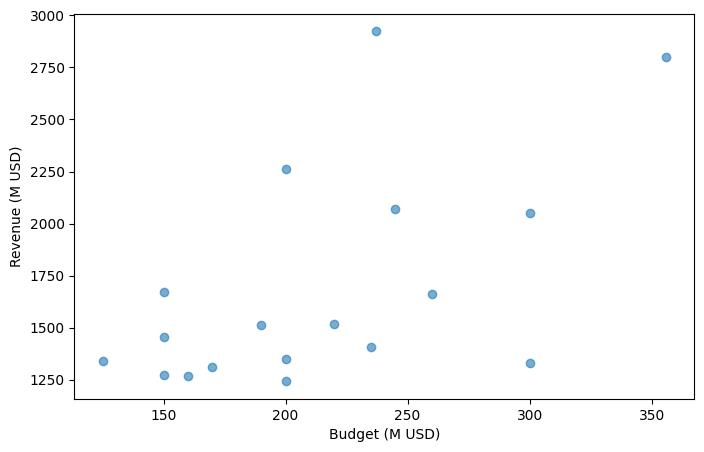

In [27]:
# Collect data as arrays
budget_data = final_df.select("budget_musd").rdd.map(lambda row: row[0]).collect()
revenue_data = final_df.select("revenue_musd").rdd.map(lambda row: row[0]).collect()

plt.figure(figsize=(8,5))
plt.scatter(budget_data, revenue_data, alpha=0.6)
plt.xlabel("Budget (M USD)")
plt.ylabel("Revenue (M USD)")


/tmp/ipykernel_11631/255748746.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(roi_values, labels=genres)


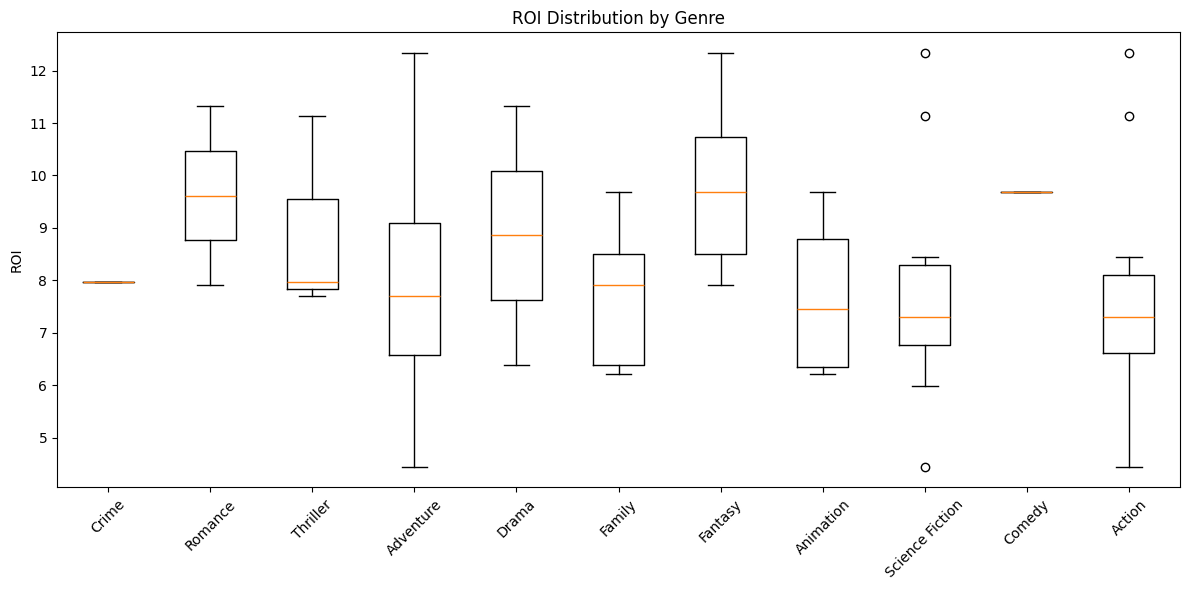

In [28]:
# Explode genres and calculate ROI by genre
genre_roi = final_df.select("roi", explode(split(col("genres"), "\\|")).alias("genre")) \
    .filter(col("roi") > 0) \
    .groupBy("genre") \
    .agg(collect_list("roi").alias("roi_values"))

# Collect data for plotting
genre_data = genre_roi.collect()

# Create box plot
plt.figure(figsize=(12, 6))
genres = [row['genre'] for row in genre_data]
roi_values = [row['roi_values'] for row in genre_data]

plt.boxplot(roi_values, labels=genres)
plt.xticks(rotation=45)
plt.ylabel('ROI')
plt.title('ROI Distribution by Genre')
plt.tight_layout()
plt.show()


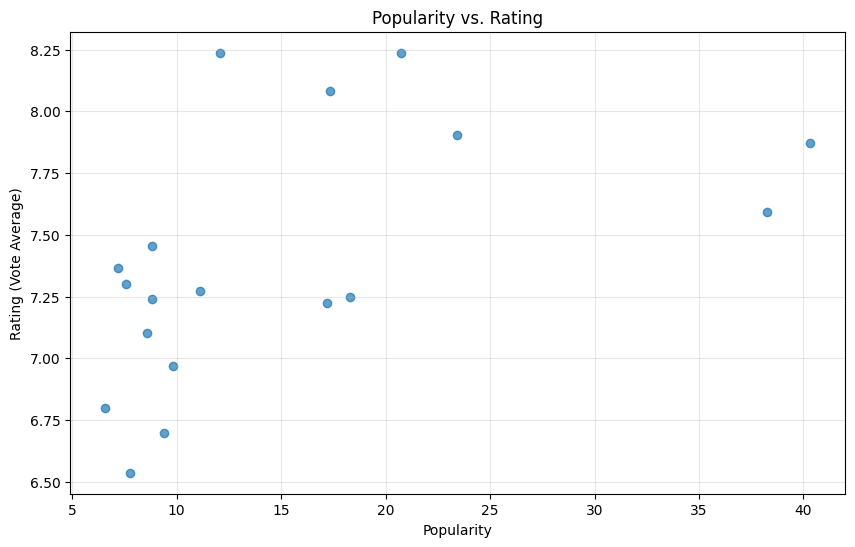

In [29]:
# Collect data for plotting
data = final_df.select("popularity", "vote_average").collect()
popularity = [row[0] for row in data]
rating = [row[1] for row in data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(popularity, rating, alpha=0.7)
plt.xlabel('Popularity')
plt.ylabel('Rating (Vote Average)')
plt.title('Popularity vs. Rating')
plt.grid(True, alpha=0.3)
plt.show()


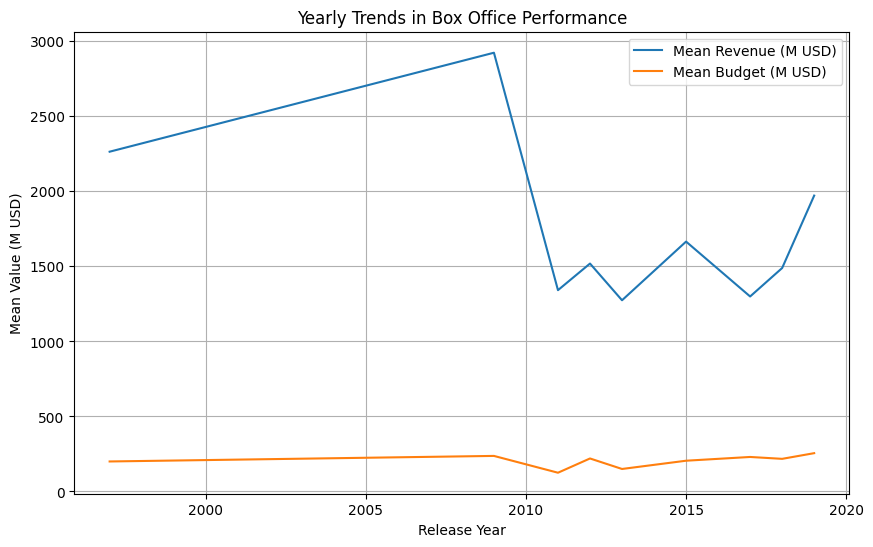

In [32]:
# Extract year and calculate mean values only (like pandas version)
yearly_trends = final_df.withColumn("year", year(col("release_date"))) \
    .groupBy("year") \
    .agg(avg("revenue_musd").alias("avg_revenue"), 
         avg("budget_musd").alias("avg_budget")) \
    .orderBy("year")

# Collect data for plotting
data = yearly_trends.collect()
years = [row['year'] for row in data]
avg_revenue = [row['avg_revenue'] for row in data]
avg_budget = [row['avg_budget'] for row in data]

# Create line plot (matching pandas version)
plt.figure(figsize=(10,6))
plt.plot(years, avg_revenue, label="Mean Revenue (M USD)")
plt.plot(years, avg_budget, label="Mean Budget (M USD)")
plt.xlabel("Release Year")
plt.ylabel("Mean Value (M USD)")
plt.title("Yearly Trends in Box Office Performance")
plt.legend()
plt.grid(True)
plt.show()


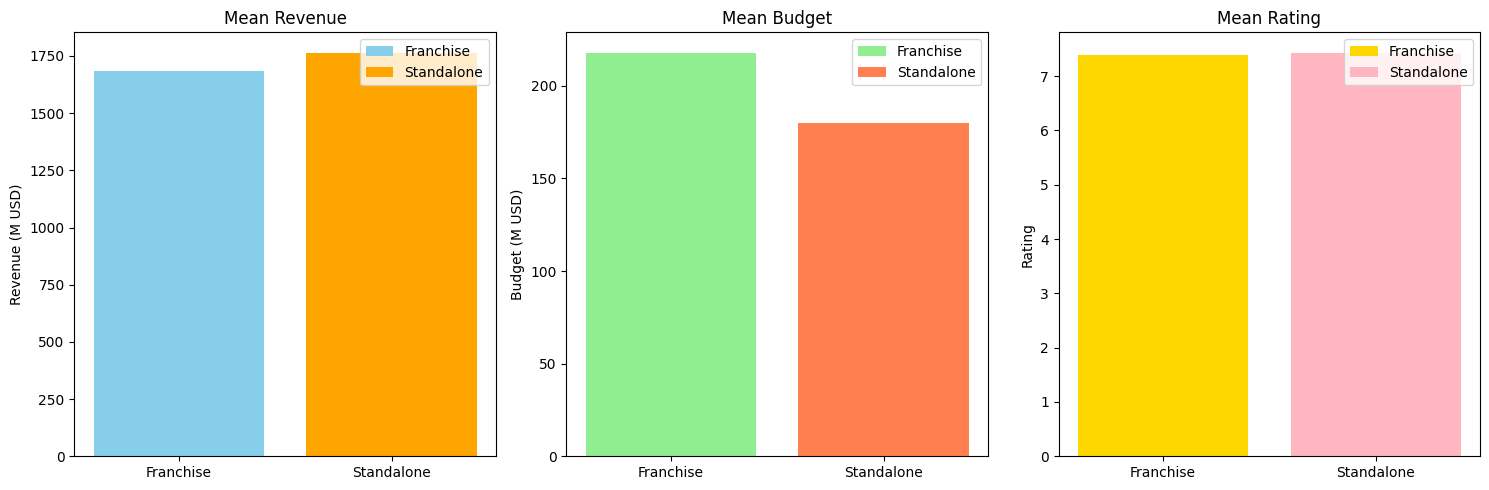

In [39]:
# Create bar chart comparison with different colors and legends
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

bars1 = axes[0].bar(categories, revenue, color=['skyblue', 'orange'])
axes[0].set_title('Mean Revenue')
axes[0].set_ylabel('Revenue (M USD)')
axes[0].legend(bars1, categories)

bars2 = axes[1].bar(categories, budget, color=['lightgreen', 'coral'])
axes[1].set_title('Mean Budget')
axes[1].set_ylabel('Budget (M USD)')
axes[1].legend(bars2, categories)

bars3 = axes[2].bar(categories, rating, color=['gold', 'lightpink'])
axes[2].set_title('Mean Rating')
axes[2].set_ylabel('Rating')
axes[2].legend(bars3, categories)

plt.tight_layout()
plt.show()
